# MicroGrid Energy Management

## Summary

The goal of the Microgrid problem is to compute an optimal power flow within the distributed sources, loads, storages and a main grid. On a given time horizon $H$, the optimal power flow poblem aims to find the optimal command of the components, e.g.charging/discharging for storage, seeling/buying for external power sources, turning on/off intellingent loads, etc. KNowing that the power balance must be respected $\forall t\in[0,H]$. 

This problem can be formulated as a mixed integer linear program, for which constraints, variables and objectives are organized using pyomo blocks. 

<img src="figures/mg_pv_bat_eol_house.png" width="500">

## Problem Statement

The Energy Management problem can be formulated mathematically as a mixed integer linear problem using the following model.   

Plan : 
1. Definition of sets
2. Definitions of distributed sources, loads and charges.
3. Definition of the global constraint (Power balance)
4. Definition of the objective

### Sets

The micogrid modelling equieres only one Coninuous Set : the time. We not H the horizon in seconds. 

In [1]:
from pyomo.environ import *
from pyomo.dae import ContinuousSet, Integral

H = 60*60*24 # Time horizon in seconds

m = AbstractModel()
m.time = ContinuousSet(initialize=(0, H))

### Blocks

The microgrid is created by connecting units together, such as batteries, loads, renewable sources, etc. In the pyomo vocabulary, such a components is called a block. 

As a first step, the microgrid is constituted of a renewable power source (PV panel), a critical load, and a connection to the main grid.

A quick descipion of the usefull blocks is following : 

 - **Maingrid** : A block that describes the model of the distribution grid connection, a base version, named `AbsMainGridV0` is available in `microgrids.maingrids`.
 - **Renewable Power Source** : A block that describes the model of a PV panels. This will be modeled by a deterministic power profile using a `Param` indexed by the time. Such a block is available in `microgrids.sources.AbsFixedPowerSource`.  
 - **Power Load** : A block that describes the model of a critical load. This will be modeled by a deterministic power profile using a `Param` indexed by the time. Such a block is available in `microgrids.sources.AbsFixedPowerLoad`. 
 
Blocks are added to the main problem as follow :  

In [2]:
from batteries import AbsBatteryV0
from maingrids import AbsMainGridV0
from sources import AbsFixedPowerLoad, AbsFixedPowerSource

m.mg = AbsMainGridV0()
m.s  = AbsFixedPowerSource()
m.l  = AbsFixedPowerLoad()

Each block is described by a set of constrains, variables, parameter and expressions.

One can print any pyomo object using the `pprint` method. Example : 
  
    m.mg.pprint()
One can access documentation of any object using the builtIn method `doc` or `help` function (for heritance). Pop-up documentation shortcut : `Shift+Tab`.

    print(m.mg.doc)
    help(m.mg)
    
Let's have a look to the maingrid block : 

### Global Power Constraint

The electical connection between blocks is modelled using constraints, aka Kirchhoff’s Laws or power balance :  $$\sum P_{sources}(t) = \sum P_{loads}(t), \forall t \in [0, H] $$

In [3]:
@m.Constraint(m.time)
def power_balance(m, t):
    return m.mg.p[t] + m.s.p[t] == m.l.p[t]

### Objectif

As a first hypothesis, we will only consider a fixed selling/buying price of energy $c$, such that : $$J = \int_{0}^{H} c.p_{mg}(t)$$.

Pyomo allows you to make integrals over a continuous set as follow : 


In [4]:
m.int = Integral(m.time, wrt=m.time, rule=lambda m, i: m.mg.inst_cost[i])
m.obj = Objective(expr=m.int)

## Instantiate the problem, discretize it and solve it

`m` is a pyomo Abstract Model, as we saw in the pyomo tutorial. Which meens that the structure of the problem is now completlty defined and may be used for different scenarios or cases. The fllowing steps consern :

1. Loading data (scenario, predictions and sizing of the components)
2. Instantiate the problem
3. Discretization
4. Solving

### Loading data

Parameters, loads and source profiles are already defined in the file `data/datamodels.py`. One can load it and plot PV and Load profiles as followed :

In [5]:
%run data/data_models.py
df_s[['P_pv', 'P_load_1']].plot(figsize=(15,3))

/home/admin/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


### 2. Problem Instantiation

The abstract model is instanciate by the previously definied data dictionnary, as follow :

In [6]:
inst = m.create_instance(data)

### Discretization

After instantiation, one can discretize the problem equation over the time horizon. In the folowing, we choose a number of finite element $nfe = 96$ i.e. every $15~ min$ for $H=1\ day$.

In [7]:
from pyomo.environ import TransformationFactory
inst = m.create_instance(data)

nfe = 60*60*24/(15*60)
TransformationFactory('dae.finite_difference').apply_to(inst, nfe=nfe)

### Solving

The problem is solve as follow :

In [8]:
opt = SolverFactory("glpk")
res = opt.solve(inst, load_solutions=True)

## Post-Processing

([<matplotlib.axes._subplots.AxesSubplot at 0x7f966d45c198>,
 <Figure size 720x360 with 1 Axes>)

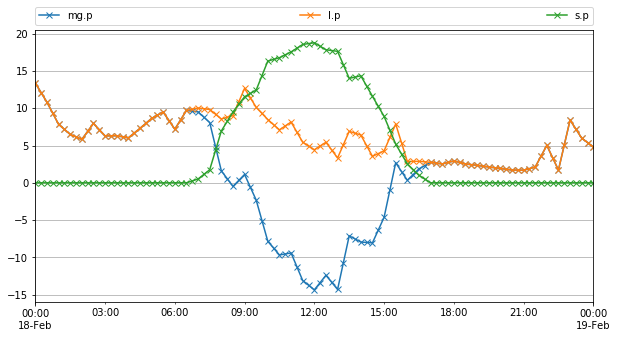

In [9]:
from utils import pplot
index = pd.date_range(start = TSTART, end = TEND, periods = nfe+1)
pplot(inst.mg.p, inst.l.p, inst.s.p, index = index, marker='x', figsize=(10,5))